<a href="https://colab.research.google.com/github/afhamash/Estimators/blob/main/EstimatorsMLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [30]:
import numpy as np
import cvxpy as cp
import scipy as sp
import random
import time
import functools as ft  # needed from defining the function multiKron()
from matplotlib import pyplot as plt

from numpy import linalg as la
from scipy import linalg as sla
from scipy import optimize as opt
from scipy.optimize import minimize
from scipy.linalg import sqrtm as sqm
from numpy import trace as tr
from numpy import allclose as ac
from numpy.linalg import eigh as eigh
from numpy.linalg import norm as norm
from scipy.linalg import inv as inv
from scipy.linalg import pinv as pinv
from collections import Counter
from math import comb


rng = np.random.default_rng()
from numpy.linalg import norm
from scipy.stats import unitary_group as Unitary
from matplotlib.colors import TwoSlopeNorm
from matplotlib import rc
rc('animation', html='jshtml')
from sklearn.metrics import auc
from scipy.stats import bernoulli

# General definitions

In [3]:
# Initialize ggplot style for plots
plt.style.use('ggplot')
from matplotlib import rc
rc('animation', html='jshtml')

In [4]:
%matplotlib inline
from IPython.display import HTML

In [5]:
np.set_printoptions(precision=4)

In [6]:
# Define Pauli matrices
PI = np.array([[1, 0],[0, 1]], dtype = 'complex128')
PX = np.array([[0, 1],[1, 0]], dtype = 'complex128')
PY = np.array([[0, 0 - 1j],[0 + 1j, 0]], dtype = 'complex128')
PZ = np.array([[1, 0],[0, -1]], dtype = 'complex128')

#Defined as a tuple since pauli matrices need not be changed later on
Paulis = (PI, PX, PY, PZ)

In [7]:
# Returns a complex Positive semidefinite matrix.
def PSDMatrix(Dim, Rank):
  X = 2*np.random.randn(Dim, Rank) - 1 + 1j*(2*np.random.randn(Dim, Rank) - 1)
  return X@(X.conj().T)

def DensityMatrix(Dim, Rank, IsReal = 0):
  if IsReal == 1:
    X = np.random.randn(Dim, Rank) # Generate random matrix
  else:
    X = np.random.randn(Dim, Rank) + 1j*(np.random.randn(Dim, Rank))

  P = X@(X.conj().T)   #Multiply by its transpose to obtain PSD matrix
  return P/np.trace(P)  #Normalise to obtain density matrix


# Return an n dimensional probability vector
def ProbVec(n):
  p = np.random.rand(n)
  return p/np.sum(p)

# Faster way of computing trace inner product
def TrInnerProduct(A,B):
  return float(np.real(np.dot(A.flatten().conj(), B.flatten().T)))

TIP = TrInnerProduct

def TraceDistance(Rho, Sigma):
  return la.norm(Rho - Sigma, 'nuc')/2


def Fidelity(Rho, Sigma):
  return tr(sqm(Rho@Sigma))
  # SqRho = sqm(Rho)
  # return tr(sqm(SqRho@Sigma@SqRho))

def multiKron(*matrices):

  try:
    if len(matrices) == 1:
      matrices = matrices[0]
    M = ft.reduce(np.kron, matrices)
    return M
  except TypeError:
    raise Exception('multiKron() must recieve at least 2 matrices as input.')

In [272]:
# Functions used to construct Pauli strings
def list_base4(number):
    if number == 0:
      yield 0
    else:
      while number > 0:
        number, digit = divmod(number, 4)
        yield digit

def stringToPauliString(s):
  P = 1 + 0j
  for i in s:
    P = np.kron(P, Paulis[int(i)])
  return P

In [123]:
def generatePauliBasis(n):

  temp = [list(list_base4(i)) for i in range(4**n)]
  # gets a list of base4 representation of every number from 0 to n-1

  base4Lists = [reversed(l) for l in temp] # reverse to get the correct ordering
  base4Strings = []  # we want the string representation, not list representation.
  for l in base4Lists:
    s = [str(j) for j in l]
    base4Strings += [''.join(s)]  # convert to string format (from list)

  pauliNumberStrings = ['0'*(n-len(s))+s for s in base4Strings]  # append zeros to make every string of length n

  PauliMatrices = [stringToPauliString(s) for s in pauliNumberStrings]  # create the Pauli matrix strings from letter strings

  PauliArray = [np.reshape(P, newshape = (1, 2**(2*n))) for P in PauliMatrices]  # An array of the Pauli basis elements

  PauliMap = np.concatenate(PauliArray, axis = 0) # A d**2 x d**2 matrix whose rows correspond to the flattened Pauli matrices

  return (PauliMatrices, PauliMap)

In [275]:
# Given a vector that sums to 1, returns the nearest
# (in terms of Euclidean distance) probability vector
def FrobeniusProjection(vec, epsi = 0):
  d = len(vec)
  theta = np.random.uniform(-1, 1, d) #Random initialization

  fun = lambda x: np.linalg.norm(x - vec) ** 2
  cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1})
  bnds = tuple([(epsi,1) for i in range(d)])
  res = minimize(fun, theta, bounds = bnds, constraints = cons, tol = 1e-8)
  return res.x

In [276]:
# Returns an object of Pauli class
class Pauli:

  def __init__(self, numberOfQubits):
    self.I = PI
    self.X = PX
    self.Y = PY
    self.Z = PZ
    self.elements, self.measurementMap = generatePauliBasis(numberOfQubits)


In [16]:
class RandomQuantumState:

  def __init__(self, dim, rank, isReal = 0):
    pauliMeasurementMap = generatePauliBasis(int(np.log2(dim)))[1]
    self.dim = dim
    self.rank = rank
    self.denMat = DensityMatrix(dim, rank, isReal)
    # self.blochVector = np.array((TIP(PX, self.denMat), TIP(PY, self.denMat), TIP(PZ, self.denMat)))
    self.blochVector = pauliMeasurementMap@self.denMat.flatten()  # Might need to normalize by a factor of sqrt(d)


  def expectation(self, Observable):
    return TIP(Observable, self.denMat)


class ToQuantumState:

  def __init__(self, densityMatrix):
    pauliMeasurementMap = generatePauliBasis(int(np.log2(dim)))[1]
    self.denMat = densityMatrix
    self.dim = int((np.shape(self.denMat)[0]))
    # self.rank = rank
    self.blochVector = pauliMeasurementMap@self.denMat.flatten()  # Might need to normalize by a factor of sqrt(d)

  def expectation(self, Observable):
    return TIP(Observable, self.denMat)

In [168]:
# Use this instead of RandomQuantumState or ToQuantumState
class QuantumState:

  def __init__(self, *args, dim, rank, isReal = 0):
    pauliMeasurementMap = generatePauliBasis(int(np.log2(dim)))[1]
    # print(args)
    if args == ():
      self.denMat = DensityMatrix(dim, rank, isReal)
      self.dim = dim
      self.rank = rank
    else:
      self.denMat = args[0]
      self.dim = int((np.shape(self.denMat)[0]))
    self.blochVector = np.real(pauliMeasurementMap@self.denMat.flatten())

  def toRebitVector(self):
    if self.dim == 2:
      return np.array((TIP(PX, self.denMat), TIP(PZ, self.denMat)))
    else:
      raise Exception('State must be 2-dimensional for rebit vector')

  def expectation(self, Observable):
    return TIP(Observable, self.denMat)

  def fidelity(self, sigma):  # computes fidelity with another density matrix sigma
    return Fidelity(self.denMat, sigma)

  def traceDistance(self, sigma):  # computes fidelity with another density matrix sigma
    return TraceDistance(self.denMat, sigma)

  def pauliMeasFreqs(self, Nmeas):
    outcomes = [np.random.choice([0, 1], size = Nmeas, p = np.array([1+b, 1-b])/2) for b in self.blochVector]
    freqs = [(list(l).count(0), list(l).count(1)) for l in outcomes]
    # probs = [np.array([1+b, 1-b])/2 for b in self.blochVector]
    # freqs = [np.random.choice([0,1], size = Nmeas, p = r) for r in probs]
    return np.array(freqs)

  def measurementFreqs(self, Nmeas, measurement):
    sampleSpace = np.arange(len(measurement))
    probs = [np.real(TIP(self.denMat, M)) for M in measurement]
    outcomes = np.random.choice(sampleSpace, size = Nmeas, p = probs)



In [304]:
# A class whose objects correspond to outcomes of Pauli measurements.
# Methods are different estimators which return the estimates
class PauliOutcomes:

  def __init__(self, counts):
    self.counts = counts

  def LI(self):
    v = self.counts
    d = int(np.sqrt(v.shape[0]))
    PauliMap = generatePauliBasis(int(np.log2(d)))[1]
    BlochEstimate = (v[:,0] - v[:,1])/v[0,0]  # v[0,0] is always the total number of measurements in each axis
    LIestimate = (inv(PauliMap)@BlochEstimate).reshape(d, d)
    return LIestimate

  def PLS(self, eps = 0.0):
    LIestimate = self.LI()
    D, U = la.eigh(LIestimate)
    Proj_D = FrobeniusProjection(D, eps)
    PLSEstimate = U@np.diag(Proj_D)@U.conj().T
    # print(PLSEstimate)
    return PLSEstimate


In [305]:
# Generate m instances of QuantumState object
def GenQuantumStates(m, dim, rank):
  States = [QuantumState(dim = dim, rank = rank) for i in range(m)]
  return States

In [319]:
def PlotStates(blochVectors):

  fig, axs = plt.subplots(figsize = (5,5))
  axs.scatter(blochVectors[:,0], blochVectors[:,1])

  axs.set_xlim(-1.2, 1.2)
  axs.set_ylim(-1.2, 1.2)
  Circ = plt.Circle((0, 0), 1,fill = False, ec = 'black')
  axs.add_artist(Circ)
  axs.set_aspect(1)
  fig.show()

# Numerics

In [353]:
Rho = QuantumState(dim = 2, rank = 2, isReal = 1)
m = 10
RhoOutcomes = PauliOutcomes(Rho.pauliMeasFreqs(m))

RhoLI = QuantumState(RhoOutcomes.LI(), dim = 2, rank = 2)
RhoPLS = QuantumState(RhoOutcomes.PLS(), dim = 2, rank = 2)
RhoIPLS = QuantumState(RhoOutcomes.PLS(eps = 1e-1), dim = 2, rank = 2)

blochVectors = np.array([Rho.toRebitVector(), RhoLI.toRebitVector(), RhoPLS.toRebitVector(), RhoIPLS.toRebitVector()])
blochVectors

array([[-8.3953e-01, -3.1582e-01],
       [-1.0000e+00,  0.0000e+00],
       [-8.5749e-01, -1.1102e-16],
       [-6.8599e-01, -1.1102e-16]])

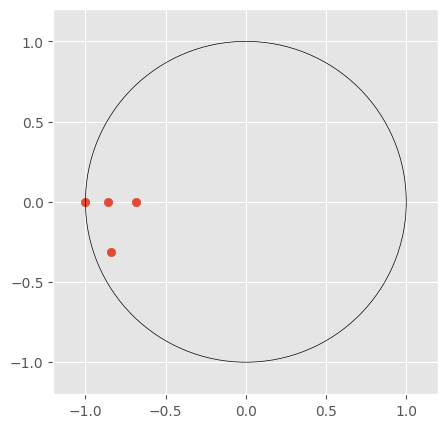

In [354]:
PlotStates(blochVectors)

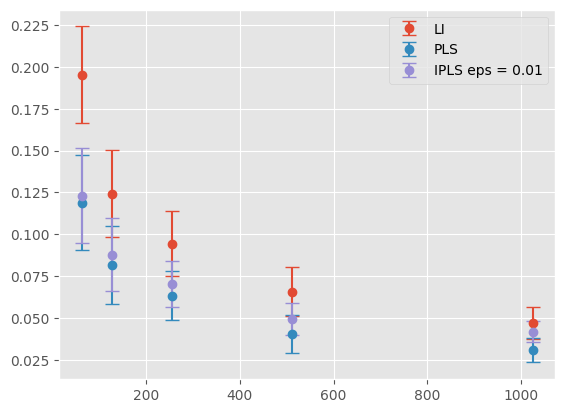

In [271]:
NMeas = [2**i for i in range(6, 11)]

eps = 1e-2
LIArray, PLSArray, IPLSArray = np.zeros((20, 5)), np.zeros((20, 5)), np.zeros((20, 5))
for k in range(20):
  LIs = []
  PLSs = []
  IPLSs = []
  for m in NMeas:
    RhoOutcomes = PauliOutcomes(Rho.pauliMeasFreqs(m))
    LIest = RhoOutcomes.LI()
    PLSest = RhoOutcomes.PLS()
    IPLSest = RhoOutcomes.PLS(eps)

    LIs.append(Rho.traceDistance(LIest))
    PLSs.append(Rho.traceDistance(PLSest))
    IPLSs.append(Rho.traceDistance(IPLSest))

  LIArray[k,:] = np.array(LIs)
  PLSArray[k,:] = np.array(PLSs)
  IPLSArray[k,:] = np.array(IPLSs)

plt.errorbar(NMeas, np.average(LIArray, axis = 0), yerr = np.std(LIArray, axis = 0), fmt='o', capsize=5, label = 'LI')
plt.errorbar(NMeas, np.average(PLSArray, axis = 0), yerr = np.std(PLSArray, axis = 0), fmt='o', capsize=5, label = 'PLS')
plt.errorbar(NMeas, np.average(IPLSArray, axis = 0), yerr = np.std(IPLSArray, axis = 0), fmt='o', capsize = 5, label = 'IPLS eps = {}'.format(eps))
plt.legend()